<a href="https://colab.research.google.com/github/Cham0703/DU_AN_SPAM/blob/main/main_email_detechtion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code 1

Đã đoán encoding: Windows-1252


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



📄 Độ dài tin nhắn - HAM:
                                             message  message_length
0  Go until jurong point, crazy.. Available only ...             111
1                      Ok lar... Joking wif u oni...              29
3  U dun say so early hor... U c already then say...              49
4  Nah I don't think he goes to usf, he lives aro...              61
6  Even my brother is not like to speak with me. ...              77

📄 Độ dài tin nhắn - SPAM:
                                              message  message_length
2   Free entry in 2 a wkly comp to win FA Cup fina...             155
5   FreeMsg Hey there darling it's been 3 week's n...             148
8   WINNER!! As a valued network customer you have...             158
9   Had your mobile 11 months or more? U R entitle...             154
11  SIX chances to win CASH! From 100 to 20,000 po...             136


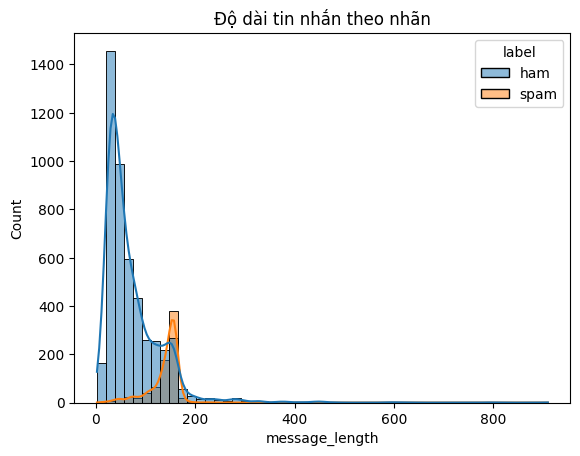


🔢 Top 10 từ SPAM phổ biến:
       word  frequency
45     call        349
34        å        270
0      free        219
52        u        155
14      txt        150
99       ur        144
50   mobile        124
11     text        121
281    stop        116
44    claim        113

🔢 Top 10 từ HAM phổ biến:
     word  frequency
20      u        988
56     im        451
242   get        307
237  ltgt        276
16     ok        272
29   dont        257
0      go        249
123    ur        240
159   ill        236
13    got        232


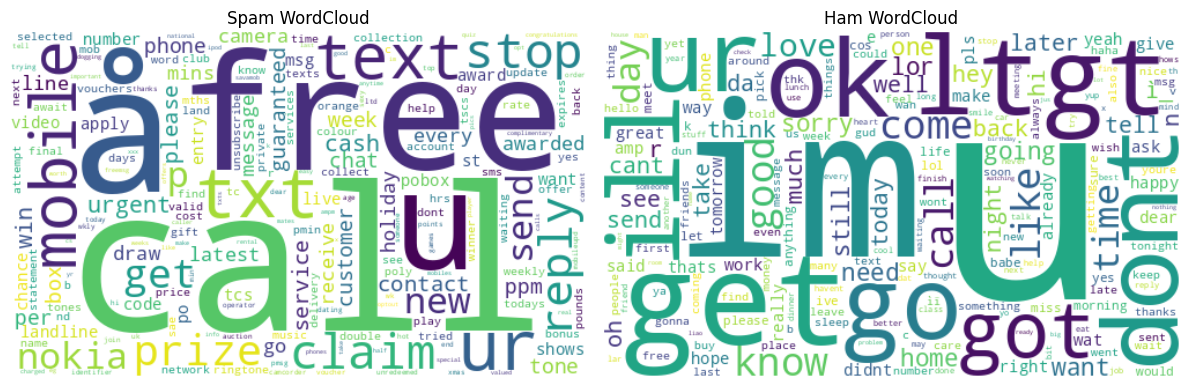


🎯 Kết quả đánh giá mô hình:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.66      0.78       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115

Độ chính xác: 0.9506726457399103


In [ ]:
#  Import thư viện
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import chardet
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from google.colab import drive
#  BƯỚC 1: Đọc file và chuẩn hóa dữ liệu
duong_dan = "spam.csv"

with open(duong_dan, "rb") as f:
    encoding = chardet.detect(f.read(10000))['encoding']
    print(f"Đã đoán encoding: {encoding}")

df = pd.read_csv(duong_dan, encoding=encoding)[['v1', 'v2']]
df.columns = ['label', 'message']

# 🧹 BƯỚC 2: Làm sạch dữ liệu
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_message(msg):
    msg = msg.lower()
    msg = re.sub(r'\d+', '', msg)
    msg = re.sub(r'[^\w\s]', '', msg)
    words = msg.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['cleaned_message'] = df['message'].apply(clean_message)

#  BƯỚC 3: Khám phá dữ liệu
df['message_length'] = df['message'].apply(len)

# Tách ra 2 bảng riêng
df_ham = df[df['label'] == 'ham'][['message', 'message_length']]
df_spam = df[df['label'] == 'spam'][['message', 'message_length']]

print("\n📄 Độ dài tin nhắn - HAM:")
print(df_ham.head())
print("\n📄 Độ dài tin nhắn - SPAM:")
print(df_spam.head())

# Vẽ biểu đồ độ dài
sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
plt.title("Độ dài tin nhắn theo nhãn")
plt.show()

# ☁️ BƯỚC 4: Tạo WordCloud + bảng tần suất
spam_words = ' '.join(df[df['label'] == 'spam']['cleaned_message']).split()
ham_words = ' '.join(df[df['label'] == 'ham']['cleaned_message']).split()

spam_freq = Counter(spam_words)
ham_freq = Counter(ham_words)

spam_freq_df = pd.DataFrame(spam_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)
ham_freq_df = pd.DataFrame(ham_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)

# Hiển thị top 10
print("\n🔢 Top 10 từ SPAM phổ biến:")
print(spam_freq_df.head(10))
print("\n🔢 Top 10 từ HAM phổ biến:")
print(ham_freq_df.head(10))

# Vẽ WordCloud
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
wordcloud_spam = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(spam_freq)
plt.imshow(wordcloud_spam, interpolation='bilinear')
plt.axis("off")
plt.title("Spam WordCloud")

plt.subplot(1, 2, 2)
wordcloud_ham = WordCloud(width=500, height=300, background_color='white').generate_from_frequencies(ham_freq)
plt.imshow(wordcloud_ham, interpolation='bilinear')
plt.axis("off")
plt.title("Ham WordCloud")

plt.tight_layout()
plt.show()

# 📈 BƯỚC 5: Chuẩn bị dữ liệu huấn luyện
X = df['cleaned_message']
y = df['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF Vectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

#  BƯỚC 6: Huấn luyện mô hình Logistic Regression
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

# 🎯 BƯỚC 7: Đánh giá mô hình
print("\n🎯 Kết quả đánh giá mô hình:")
print(classification_report(y_test, y_pred))
print("Độ chính xác:", accuracy_score(y_test, y_pred))

Code 2

In [ ]:
# 1. Tải file spam.csv từ máy tính người dùng
from google.colab import files
uploaded = files.upload()  # Chọn file spam.csv từ máy của bạn

# 2. Cài đặt thư viện cần thiết (nếu chưa có)
!pip install -q seaborn scikit-learn

# 3. Nhập các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# 4. Định nghĩa hàm xử lý dữ liệu
def preprocess_spam_data(duong_dan="spam.csv", max_features=5000, test_size=0.2, random_state=42):
    print("Đang đọc dữ liệu từ:", duong_dan)
    try:
        df = pd.read_csv(duong_dan, encoding='latin-1')

        if 'v1' in df.columns and 'v2' in df.columns:
            df = df.rename(columns={'v1': 'label', 'v2': 'message'})
        required_cols = ['label', 'message']
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"Dataset phải có các cột: {required_cols}")

        df = df[required_cols].copy()
        df['message'] = df['message'].fillna("")
        df['cleaned_message'] = df['message'].str.lower()
        df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
        if df['label_num'].isnull().any():
            most_common_label = df['label_num'].mode()[0]
            df['label_num'] = df['label_num'].fillna(most_common_label)

        print("\n--- THÔNG TIN DỮ LIỆU ---")
        print("Kích thước dữ liệu:", df.shape)
        print("Số lượng mẫu theo nhãn:")
        print(df['label'].value_counts())
        print("Số lượng mẫu theo nhãn số:")
        print(df['label_num'].value_counts())

        print("\n--- TRÍCH XUẤT ĐẶC TRƯNG ---")
        count_vectorizer = CountVectorizer(max_features=max_features)
        X_count = count_vectorizer.fit_transform(df['cleaned_message'])
        tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
        X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_message'])

        print(f"Kích thước dữ liệu CountVectorizer: {X_count.shape}")
        print(f"Kích thước dữ liệu TF-IDF: {X_tfidf.shape}")

        print("\n--- CHIA DỮ LIỆU ---")
        X_count_train, X_count_test, y_count_train, y_count_test = train_test_split(
            X_count, df['label_num'], test_size=test_size, random_state=random_state, stratify=df['label_num']
        )
        X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(
            X_tfidf, df['label_num'], test_size=test_size, random_state=random_state, stratify=df['label_num']
        )

        count_vocab = count_vectorizer.get_feature_names_out()
        tfidf_vocab = tfidf_vectorizer.get_feature_names_out()

        output_dir = "processed_data"
        os.makedirs(output_dir, exist_ok=True)

        # Lưu lại dữ liệu
        df.to_csv(f"{output_dir}/cleaned_data.csv", index=False)
        pickle.dump(count_vectorizer, open(f"{output_dir}/count_vectorizer.pkl", "wb"))
        pickle.dump(tfidf_vectorizer, open(f"{output_dir}/tfidf_vectorizer.pkl", "wb"))
        np.save(f"{output_dir}/X_count_train.npy", X_count_train.toarray())
        np.save(f"{output_dir}/X_count_test.npy", X_count_test.toarray())
        np.save(f"{output_dir}/X_tfidf_train.npy", X_tfidf_train.toarray())
        np.save(f"{output_dir}/X_tfidf_test.npy", X_tfidf_test.toarray())
        np.save(f"{output_dir}/y_train.npy", y_count_train.values)
        np.save(f"{output_dir}/y_test.npy", y_count_test.values)

        print("\n--- TỔNG KẾT ---")
        print("CountVectorizer:", X_count_train.shape, X_count_test.shape)
        print("TfidfVectorizer:", X_tfidf_train.shape, X_tfidf_test.shape)

        print("\n--- PHÂN TÍCH TỪ VỰNG ---")
        print("10 từ phổ biến nhất (CountVectorizer):")
        feature_importances = np.sum(X_count.toarray(), axis=0)
        top_indices = np.argsort(feature_importances)[-10:][::-1]
        for idx in top_indices:
            print(f"  - {count_vocab[idx]}: {feature_importances[idx]}")

        return {
            'df': df,
            'CountVectorizer': {
                'vectorizer': count_vectorizer,
                'X_train': X_count_train,
                'X_test': X_count_test,
                'y_train': y_count_train,
                'y_test': y_count_test,
                'vocabulary': count_vocab
            },
            'TfidfVectorizer': {
                'vectorizer': tfidf_vectorizer,
                'X_train': X_tfidf_train,
                'X_test': X_tfidf_test,
                'y_train': y_tfidf_train,
                'y_test': y_tfidf_test,
                'vocabulary': tfidf_vocab
            }
        }

    except Exception as e:
        print("Lỗi khi xử lý dữ liệu:", e)
        return None

# 5. Hàm vẽ biểu đồ
def visualize_data(data):
    df = data['df']
    output_dir = "visualizations"
    os.makedirs(output_dir, exist_ok=True)

    # Biểu đồ 1: Phân bố nhãn
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=df)
    plt.title('Phân bố nhãn Ham/Spam')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/label_distribution_bar.png")
    plt.close()

    # Biểu đồ 2: Độ dài tin nhắn trung bình theo nhãn
    df['message_length'] = df['message'].apply(len)
    avg_length = df.groupby('label')['message_length'].mean().reset_index()
    plt.figure(figsize=(8, 5))
    sns.barplot(data=avg_length, x='label', y='message_length')
    plt.title('Độ dài tin nhắn trung bình theo nhãn')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/avg_message_length_bar.png")
    plt.close()

    # Biểu đồ 3: Tin nhắn theo độ dài
    df['length_bin'] = pd.cut(df['message_length'], bins=[0, 50, 100, 150, 200, 300, 500, 1000])
    length_bin_counts = df.groupby(['length_bin', 'label']).size().unstack(fill_value=0)
    length_bin_counts.plot(kind='bar', figsize=(12, 6))
    plt.title('Số lượng tin nhắn theo khoảng độ dài và nhãn')
    plt.tight_layout()
    plt.savefig(f"{output_dir}/length_bins_by_label_bar.png")
    plt.close()

    # Biểu đồ 4: Từ phổ biến
    vectorizer = data['CountVectorizer']['vectorizer']
    X_all = vectorizer.transform(df['cleaned_message'])
    word_sums = np.array(X_all.sum(axis=0)).flatten()
    top_idx = np.argsort(word_sums)[-10:][::-1]
    top_words = vectorizer.get_feature_names_out()[top_idx]
    top_counts = word_sums[top_idx]

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_words, y=top_counts)
    plt.title('Top 10 từ phổ biến nhất (CountVectorizer)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"{output_dir}/top_10_words_bar.png")
    plt.close()

    print(f"Các biểu đồ đã được lưu trong thư mục: {output_dir}")

# 6. Gọi hàm xử lý và vẽ biểu đồ
processed_data = preprocess_spam_data("spam.csv")
if processed_data:
    visualize_data(processed_data)


Coder 3

Import thư viện và định nghĩa mô hình

In [ ]:
# Imports chung
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Imports model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Import cho cross-validation
from sklearn.model_selection import cross_val_score

# Import pickle để lưu mô hình
import pickle

# Định nghĩa danh sách mô hình
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(kernel='linear', probability=True),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'KNN': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(n_estimators=50),
    'Bagging': BaggingClassifier(n_estimators=50),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

Hàm đánh giá và dùng Cross- Validation đánh giá sự ổn đinh của mô *hình*

In [ ]:
# Hàm đánh giá mô hình trên tập test
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return {'Model': name, 'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}

# Hàm đánh giá cross-validation
def evaluate_model_cv(model, X, y, cv=5, scoring='f1'):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    return scores.mean(), scores.std()

Cross-validation

In [ ]:
import time
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Đánh giá bằng Cross-validation (cho tất cả mô hình)
cv_results = []
y = df['label_num']  # Sử dụng df['label_num'] làm nhãn

for feat_name, X in {
    'Count': X_count,
    'TF-IDF': X_tfidf
}.items():
    print(f"Đang xử lý đặc trưng: {feat_name}")
    for name, model in models.items():
        try:
            start_time = time.time()
            mean_score, std_score = evaluate_model_cv(model, X, y, cv=3, scoring='f1')
            elapsed_time = time.time() - start_time
            if elapsed_time > 60:
                print(f"Mô hình {name} trên {feat_name} quá chậm, bỏ qua sau {elapsed_time:.2f} giây")
                continue
            # Thêm chỉ số tổng hợp (Mean - k * Std, với k=0.5)
            stability_score = mean_score - 0.5 * std_score
            cv_results.append({
                'Feature': feat_name,
                'Model': name,
                'Mean F1-score': mean_score,
                'Std F1-score': std_score,
                'Stability Score': stability_score
            })
        except Exception as e:
            print(f"Lỗi khi chạy cross-validation cho {name} trên {feat_name}: {str(e)}")

# Chuyển kết quả thành DataFrame
df_cv_results = pd.DataFrame(cv_results)
print("\nKết quả Cross-validation:")
display(df_cv_results)

Đang xử lý đặc trưng: Count


KeyboardInterrupt: 

Huấn luyện và đánh giá

In [ ]:
# Huấn luyện và đánh giá trên tập train/test
results = []
for feat_name, (X_train, X_test, y_train, y_test) in {
    'Count': (X_count_train, X_count_test, y_count_train, y_count_test),
    'TF-IDF': (X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test)
}.items():
    print(f"\nĐánh giá với đặc trưng trên tập test: {feat_name}")
    for name, model in models.items():
        model.fit(X_train, y_train)
        res = evaluate_model(name, model, X_test, y_test)
        res['Feature'] = feat_name
        results.append(res)

# Chuyển kết quả trên tập test thành DataFrame
df_results = pd.DataFrame(results)
print("\nKết quả trên tập test:")
display(df_results)


Đánh giá với đặc trưng trên tập test: Count


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:28:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Đánh giá với đặc trưng trên tập test: TF-IDF


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:28:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Kết quả trên tập test:


,Model,Accuracy,Precision,Recall,F1-score,Feature
0,MultinomialNB,0.974888,0.917241,0.892617,0.904762,Count
1,LogisticRegression,0.981166,1.000000,0.859060,0.924188,Count
2,SVM,0.984753,0.992537,0.892617,0.939929,Count
3,DecisionTree,0.960538,0.872340,0.825503,0.848276,Count
4,RandomForest,0.972197,1.000000,0.791946,0.883895,Count
5,KNN,0.923767,1.000000,0.429530,0.600939,Count
6,AdaBoost,0.923767,0.775862,0.604027,0.679245,Count
7,Bagging,0.966816,0.930769,0.812081,0.867384,Count
8,ExtraTrees,0.976682,0.992000,0.832215,0.905109,Count
9,GradientBoosting,0.961435,0.964912,0.738255,0.836502,Count


Hiển thị top 5 mô hình tốt nhất


Top 5 mô hình trên Count dựa trên Stability Score (Cross-validation):


,Model,Mean F1-score,Std F1-score,Stability Score
2,SVM,0.909519,0.005379,0.906829
1,LogisticRegression,0.906587,0.005324,0.903925
0,MultinomialNB,0.891162,0.004780,0.888772
8,ExtraTrees,0.887867,0.005638,0.885048
4,RandomForest,0.890230,0.013204,0.883628



Kết quả trên tập test cho top 5 mô hình trên Count:


,Model,Accuracy,Precision,Recall,F1-score
0,SVM,0.984753,0.992537,0.892617,0.939929
1,LogisticRegression,0.981166,1.000000,0.859060,0.924188
2,MultinomialNB,0.974888,0.917241,0.892617,0.904762
3,ExtraTrees,0.976682,0.992000,0.832215,0.905109
4,RandomForest,0.972197,1.000000,0.791946,0.883895


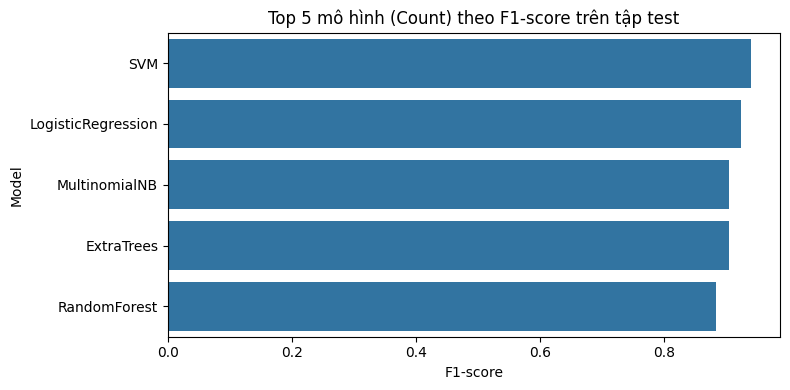


Top 5 mô hình trên TF-IDF dựa trên Stability Score (Cross-validation):


,Model,Mean F1-score,Std F1-score,Stability Score
13,SVM,0.918297,0.007431,0.914582
15,RandomForest,0.895105,0.014009,0.888100
19,ExtraTrees,0.892836,0.011578,0.887047
21,XGBoost,0.873834,0.012455,0.867607
11,MultinomialNB,0.859680,0.008309,0.855525



Kết quả trên tập test cho top 5 mô hình trên TF-IDF:


,Model,Accuracy,Precision,Recall,F1-score
0,SVM,0.983857,1.000000,0.879195,0.935714
1,RandomForest,0.973991,0.991803,0.812081,0.892989
2,ExtraTrees,0.977578,0.992063,0.838926,0.909091
3,XGBoost,0.973991,0.976190,0.825503,0.894545
4,MultinomialNB,0.966816,0.991228,0.758389,0.859316


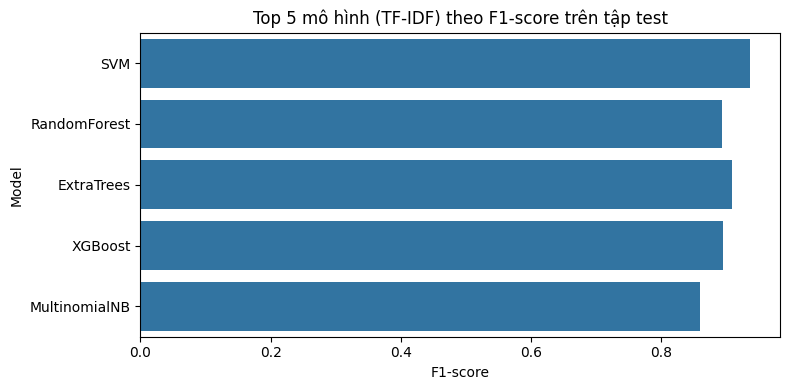

In [ ]:
# Hiển thị top 5 mô hình dựa trên Stability Score từ cross-validation
for feat in ['Count', 'TF-IDF']:
    # Lấy kết quả cross-validation cho đặc trưng hiện tại
    df_cv_feat = df_cv_results[df_cv_results['Feature'] == feat]
    # Sắp xếp theo Stability Score
    top5_cv = df_cv_feat.sort_values('Stability Score', ascending=False).head(5)
    print(f"\nTop 5 mô hình trên {feat} dựa trên Stability Score (Cross-validation):")
    display(top5_cv[['Model', 'Mean F1-score', 'Std F1-score', 'Stability Score']])

    # Kết hợp với kết quả trên tập test
    df_test_feat = df_results[df_results['Feature'] == feat]
    top5_combined = pd.merge(top5_cv[['Model']], df_test_feat, on='Model', how='left')
    print(f"\nKết quả trên tập test cho top 5 mô hình trên {feat}:")
    display(top5_combined[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']])

    # Vẽ barplot F1-score trên tập test
    plt.figure(figsize=(8, 4))
    sns.barplot(data=top5_combined, x='F1-score', y='Model')
    plt.title(f"Top 5 mô hình ({feat}) theo F1-score trên tập test")
    plt.xlabel("F1-score")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()

Confusion Matrix cho 3 model tối ưu nhất


Model: SVM trên TF-IDF (Stability Score=0.9146, F1-test=0.9357, Composite Score=0.9251)


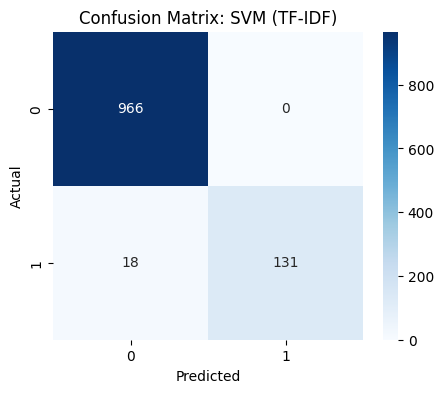


Model: SVM trên Count (Stability Score=0.9068, F1-test=0.9399, Composite Score=0.9234)


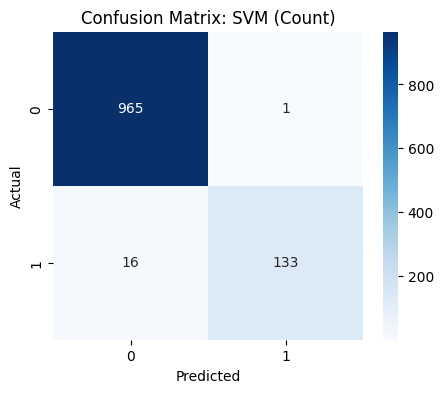


Model: LogisticRegression trên Count (Stability Score=0.9039, F1-test=0.9242, Composite Score=0.9141)


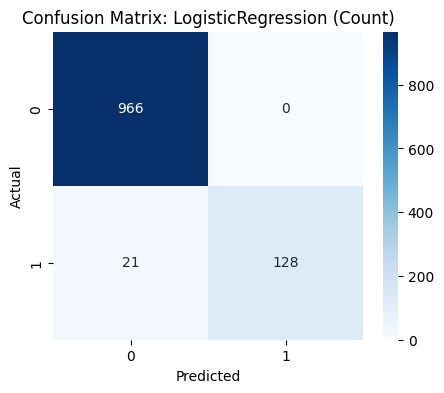

In [ ]:
# Kết hợp Stability Score và F1-score từ tập test
# Gộp df_cv_results và df_results
combined_results = pd.merge(df_cv_results[['Feature', 'Model', 'Stability Score']],
                          df_results[['Feature', 'Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']],
                          on=['Feature', 'Model'],
                          how='inner')

# Tính chỉ số tổng hợp (ví dụ: 0.5 * Stability Score + 0.5 * F1-score)
combined_results['Composite Score'] = 0.5 * combined_results['Stability Score'] + 0.5 * combined_results['F1-score']

# Chọn top 3 mô hình dựa trên Composite Score
top3_overall = combined_results.sort_values('Composite Score', ascending=False).head(3)

# In thông tin và vẽ ma trận nhầm lẫn cho top 3
for index, row in top3_overall.iterrows():
    model_name = row['Model']
    feat = row['Feature']
    stability_score = row['Stability Score']
    f1_test = row['F1-score']
    composite_score = row['Composite Score']

    print(f"\nModel: {model_name} trên {feat} (Stability Score={stability_score:.4f}, F1-test={f1_test:.4f}, Composite Score={composite_score:.4f})")

    # Chọn dữ liệu train/test dựa trên đặc trưng
    best_model = models[model_name]
    if feat == 'TF-IDF':
        X_tr, X_te, y_tr, y_te = X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test
    else:
        X_tr, X_te, y_tr, y_te = X_count_train, X_count_test, y_count_train, y_count_test

    # Huấn luyện mô hình và dự đoán
    best_model.fit(X_tr, y_tr)
    y_pred = best_model.predict(X_te)
    cm = confusion_matrix(y_te, y_pred)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix: {model_name} ({feat})')
    plt.show()

Lưu lại Model

In [ ]:
with open('best_spam_model.pkl','wb') as f:
    pickle.dump({
        'model': best_model,
        'vectorizer': tfidf_vectorizer
    }, f)
print("Đã lưu model và vectorizer vào best_spam_model.pkl")


Đã lưu model và vectorizer vào best_spam_model.pkl
